In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import h5py

In [2]:
import scvi
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
adatas = [x for x in os.listdir('/mnt/c/Users/ethan/OneDrive/桌面/Heter_Neu/rawdata/') if x.endswith('2042_00_BAL.h5')]

In [5]:
adatas

['2042_00_BAL.h5']

In [6]:
def load_it(adata):
    samp = adata.split('_')[0]
    days = adata.split('_')[1]
    ty = adata.split('_')[2].replace('.h5','')
    adata = sc.read_10x_h5('/mnt/c/Users/ethan/OneDrive/桌面/Heter_Neu/rawdata/' + adata)
    adata.var_names_make_unique()
    adata.obs['Patient'] = samp
    adata.obs['Days'] = days
    adata.obs['Type'] = ty
    adata.obs['Sample'] = adata.obs['Patient'] + '_' + adata.obs['Days'] + '_' + adata.obs['Type']
    adata.obs.index = adata.obs.index + '-' + samp + '_' + days + '_' + ty
    return adata

In [7]:
adatas = [load_it(ad) for ad in adatas]

In [8]:
adatas

[AnnData object with n_obs × n_vars = 221255 × 37143
     obs: 'Patient', 'Days', 'Type', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome']

In [9]:
adata = sc.concat(adatas, join='outer')

In [11]:
adata.raw = adata

In [12]:
print (adata.raw)

Raw AnnData with n_obs × n_vars = 221255 × 37143


In [13]:
sample_info = []
for sample in adata.obs['Sample'].unique():
    sample_data = adata[adata.obs['Sample'] == sample]
    sample_info.append([sample, sample_data.n_obs, sample_data.n_vars])

df = pd.DataFrame(sample_info, columns=['Sample_ID', 'Cell_Number', 'Gene_Number'])

df

Sample_ID  Cell_Number  Gene_Number
0  2042_00_BAL       221255        37143

In [15]:
#Remove genes (less than 50 cells expressed) from adata -- so here we remove genes not cells -- does not conflict with the filter below 
sc.pp.filter_genes(adata, min_counts=50)

In [16]:
#Minimal UMI counts = 30
sc.pp.filter_cells(adata, min_counts=30)

In [17]:
#here we remove cells with less than 15 genes expressed -- not conflict with the filter above
sc.pp.filter_cells(adata, min_genes=15) 

In [18]:
sample_info = []
for sample in adata.obs['Sample'].unique():
    sample_data = adata[adata.obs['Sample'] == sample]
    sample_info.append([sample, sample_data.n_obs, sample_data.n_vars])

df = pd.DataFrame(sample_info, columns=['Sample_ID', 'Cell_Number', 'Gene_Number'])

df

Sample_ID  Cell_Number  Gene_Number
0  2042_00_BAL        31886         9030

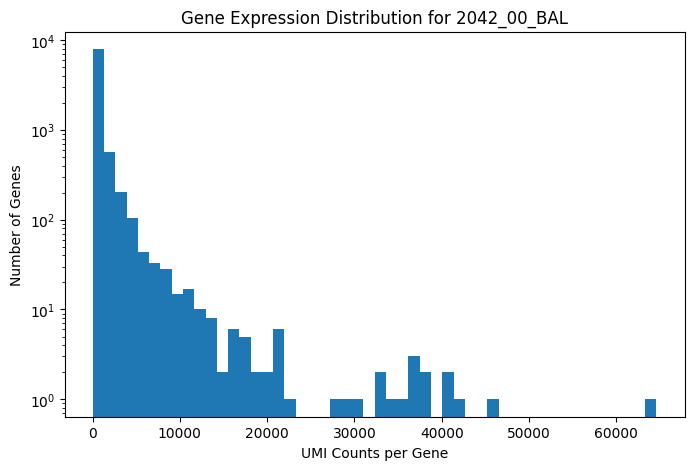

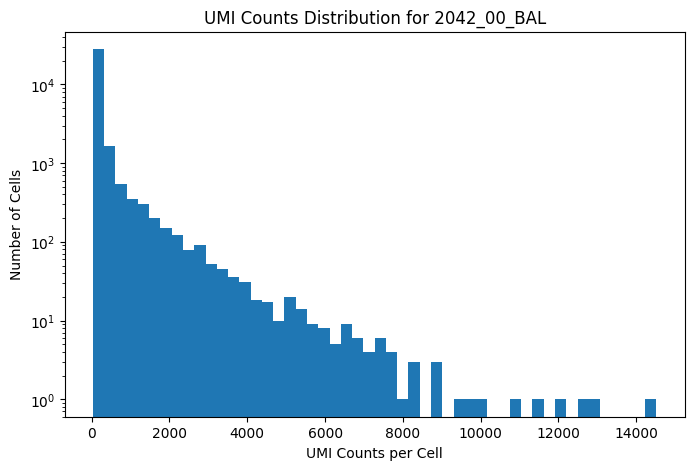

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# filter out high cell number samples >14000
high_cell_samples = df[df['Cell_Number'] > 14000]['Sample_ID']

# collect data and visualize
for sample_id in high_cell_samples:
    # pull data out
    sample_data = adata[adata.obs['Sample'] == sample_id]

    # gene counts distribution
    gene_counts = np.array(sample_data.X.sum(axis=0)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(gene_counts, bins=50, log=True)
    plt.title(f'Gene Expression Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Gene')
    plt.ylabel('Number of Genes')
    plt.show()
    
    # UMI counts distribution
    cell_counts = np.array(sample_data.X.sum(axis=1)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(cell_counts, bins=50, log=True)
    plt.title(f'UMI Counts Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Cell')
    plt.ylabel('Number of Cells')
    plt.show()


In [20]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

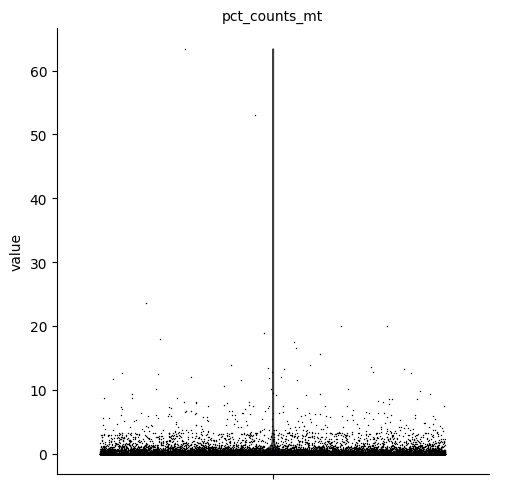

In [21]:
sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=True)

In [22]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :].copy()

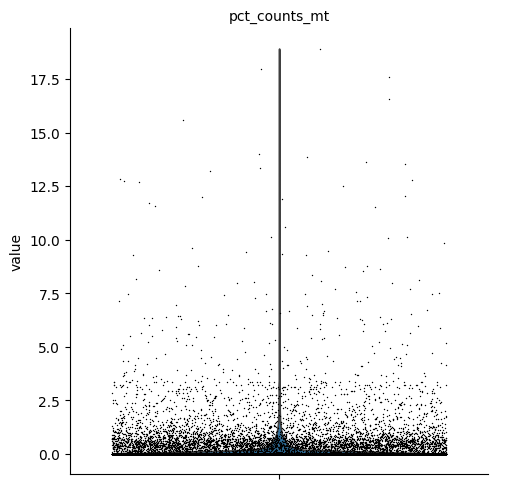

In [23]:
sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=True)

In [24]:
sample_info = []
for sample in adata.obs['Sample'].unique():
    sample_data = adata[adata.obs['Sample'] == sample]
    sample_info.append([sample, sample_data.n_obs, sample_data.n_vars])

df = pd.DataFrame(sample_info, columns=['Sample_ID', 'Cell_Number', 'Gene_Number'])

df

Sample_ID  Cell_Number  Gene_Number
0  2042_00_BAL        31881         9030

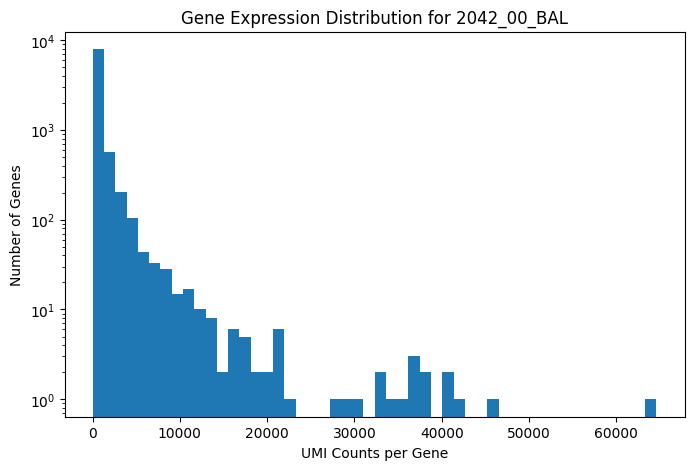

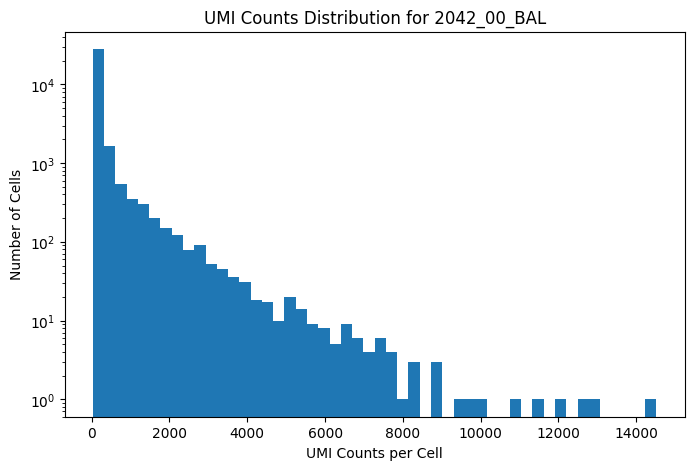

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# filter out high cell number samples >14000
high_cell_samples = df[df['Cell_Number'] > 14000]['Sample_ID']

# collect data and visualize
for sample_id in high_cell_samples:
    # pull data out
    sample_data = adata[adata.obs['Sample'] == sample_id]

    # gene counts distribution
    gene_counts = np.array(sample_data.X.sum(axis=0)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(gene_counts, bins=50, log=True)
    plt.title(f'Gene Expression Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Gene')
    plt.ylabel('Number of Genes')
    plt.show()
    
    # UMI counts distribution
    cell_counts = np.array(sample_data.X.sum(axis=1)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(cell_counts, bins=50, log=True)
    plt.title(f'UMI Counts Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Cell')
    plt.ylabel('Number of Cells')
    plt.show()


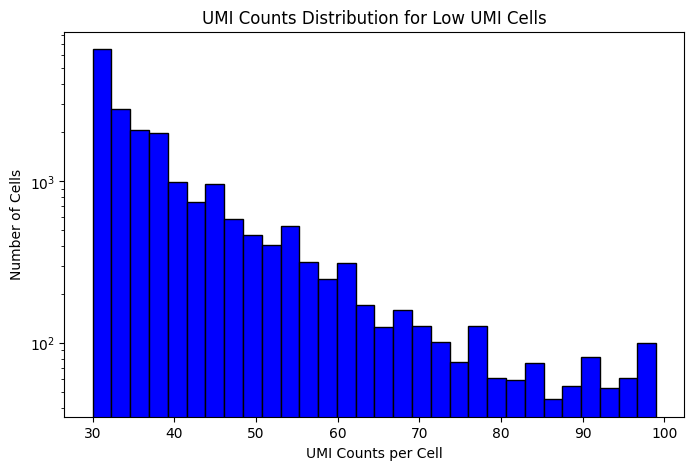

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# threshold of low umi
low_umi_threshold = 100

# pulll out low umi cells < 100
low_umi_cells = adata[adata.obs['n_counts'] < low_umi_threshold]

# pull out cell number
low_umi_counts = np.array(low_umi_cells.obs['n_counts'])

# plot
plt.figure(figsize=(8, 5))
plt.hist(low_umi_counts, bins=30, color='blue', edgecolor='black')
plt.title('UMI Counts Distribution for Low UMI Cells')
plt.xlabel('UMI Counts per Cell')
plt.ylabel('Number of Cells')
plt.yscale('log') 
plt.show()


In [27]:
#Minimal UMI counts = 50
sc.pp.filter_cells(adata, min_counts=50)

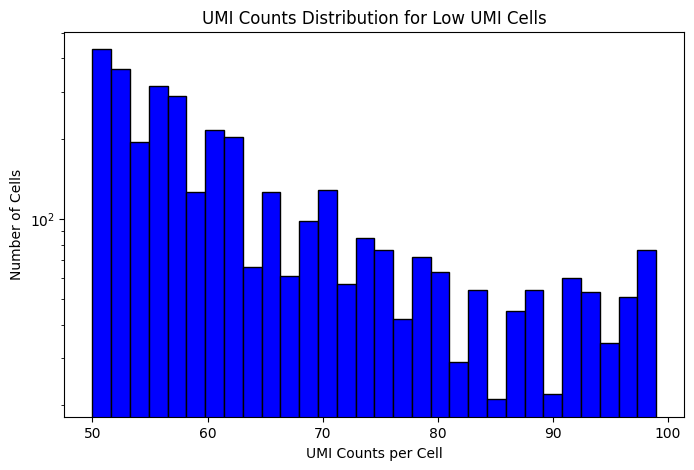

In [28]:
low_umi_threshold = 100

# pulll out low umi cells < 100
low_umi_cells = adata[adata.obs['n_counts'] < low_umi_threshold]

# pull out cell number
low_umi_counts = np.array(low_umi_cells.obs['n_counts'])

# plot
plt.figure(figsize=(8, 5))
plt.hist(low_umi_counts, bins=30, color='blue', edgecolor='black')
plt.title('UMI Counts Distribution for Low UMI Cells')
plt.xlabel('UMI Counts per Cell')
plt.ylabel('Number of Cells')
plt.yscale('log') 
plt.show()

In [29]:
sample_info = []
for sample in adata.obs['Sample'].unique():
    sample_data = adata[adata.obs['Sample'] == sample]
    sample_info.append([sample, sample_data.n_obs, sample_data.n_vars])

df = pd.DataFrame(sample_info, columns=['Sample_ID', 'Cell_Number', 'Gene_Number'])

df

Sample_ID  Cell_Number  Gene_Number
0  2042_00_BAL        15002         9030

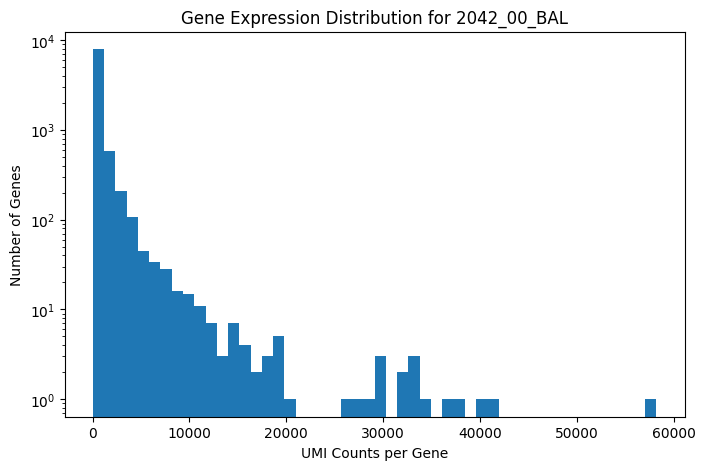

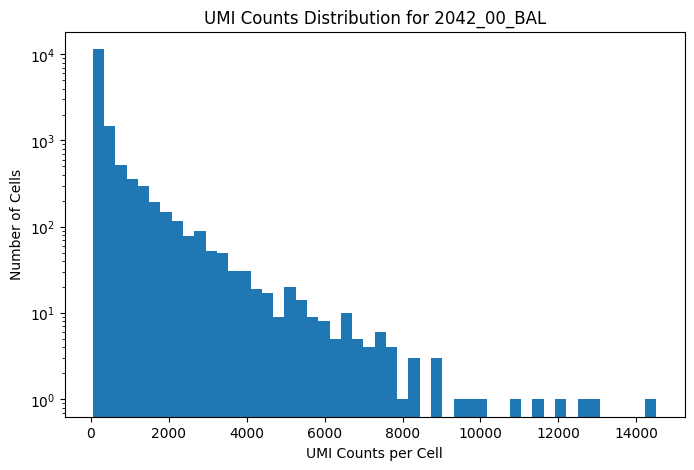

In [30]:
# filter out high cell number samples >14000
high_cell_samples = df[df['Cell_Number'] > 14000]['Sample_ID']

# collect data and visualize
for sample_id in high_cell_samples:
    # pull data out
    sample_data = adata[adata.obs['Sample'] == sample_id]

    # gene counts distribution
    gene_counts = np.array(sample_data.X.sum(axis=0)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(gene_counts, bins=50, log=True)
    plt.title(f'Gene Expression Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Gene')
    plt.ylabel('Number of Genes')
    plt.show()
    
    # UMI counts distribution
    cell_counts = np.array(sample_data.X.sum(axis=1)).flatten()
    
    plt.figure(figsize=(8, 5))
    plt.hist(cell_counts, bins=50, log=True)
    plt.title(f'UMI Counts Distribution for {sample_id}')
    plt.xlabel('UMI Counts per Cell')
    plt.ylabel('Number of Cells')
    plt.show()


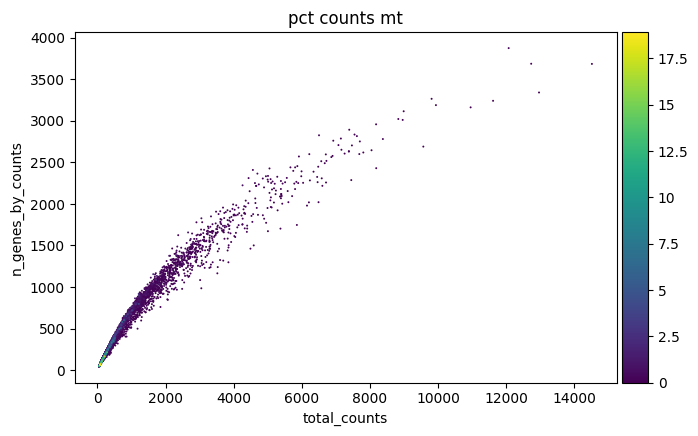

In [31]:
#UMI counts vs genes detected per cell
sc.pl.scatter(
    adata, 
    x='total_counts', 
    y='n_genes_by_counts', 
    color='pct_counts_mt', 
)

In [32]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [33]:
scvi.model.SCVI.setup_anndata(adata)

In [34]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [35]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████| 400/400 [07:11<00:00,  1.12s/it, v_num=1, train_loss_step=459, train_loss_epoch=458]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████| 400/400 [07:11<00:00,  1.08s/it, v_num=1, train_loss_step=459, train_loss_epoch=458]


In [36]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [37]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [38]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [39]:
model.save("/mnt/c/Users/ethan/OneDrive/桌面/Heter_Neu/SC1186/model-2042-BAL-00")

In [40]:
#load model

In [41]:
import torch
import tempfile
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

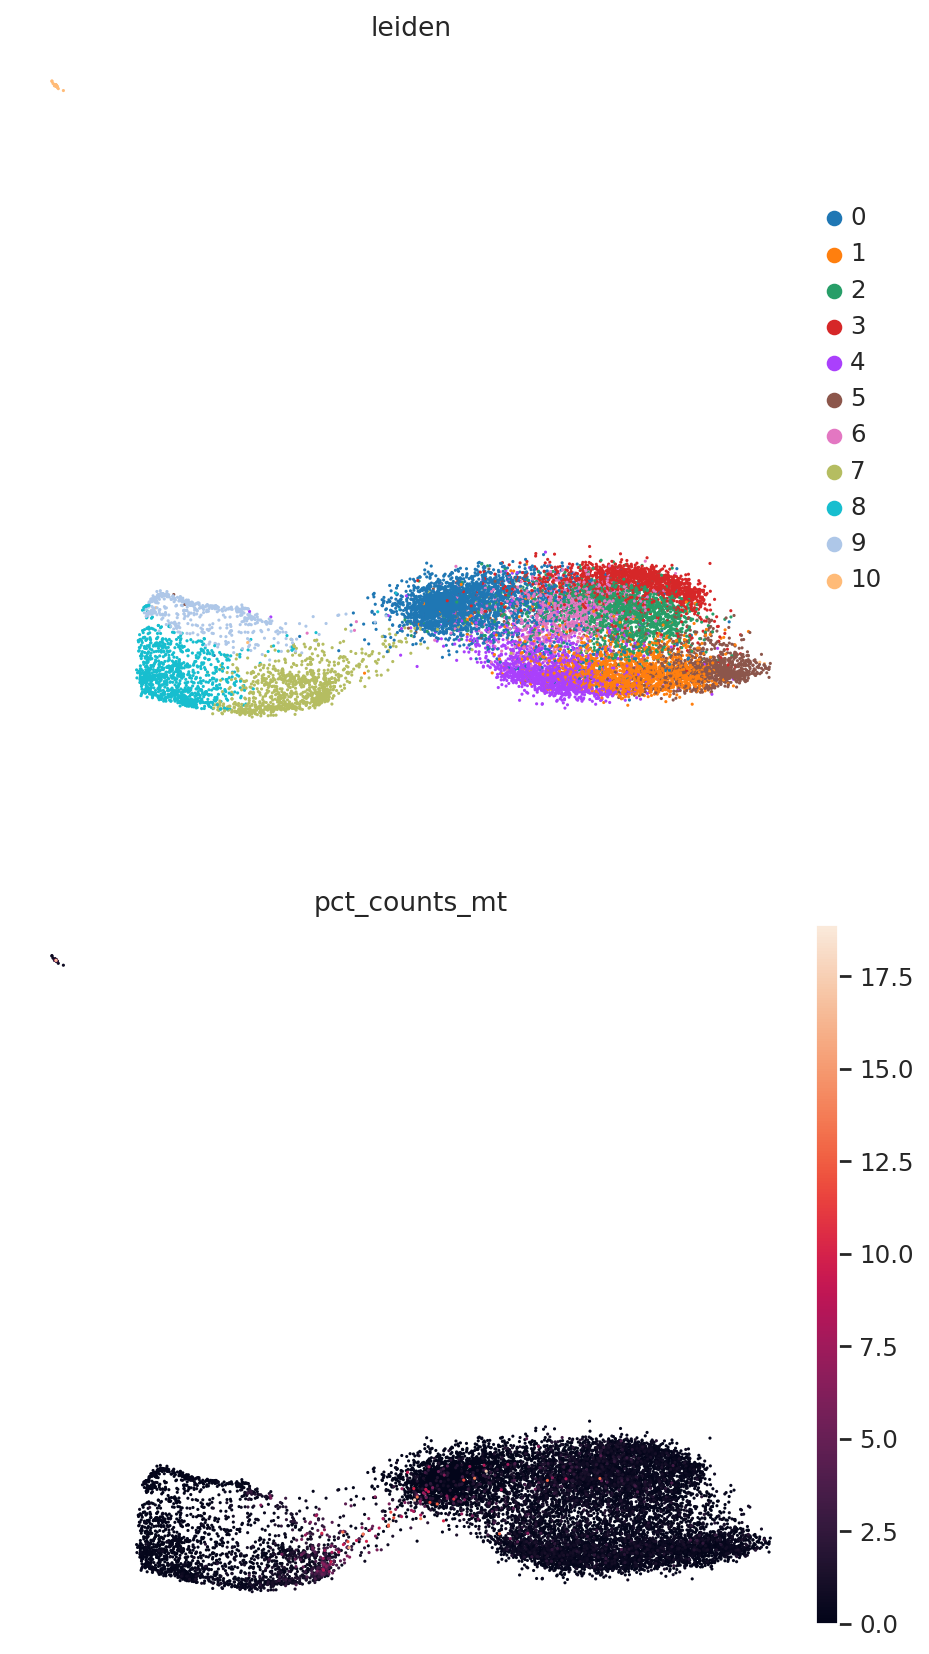

In [42]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["leiden","pct_counts_mt"],
    frameon=False,
    ncols=1,
)

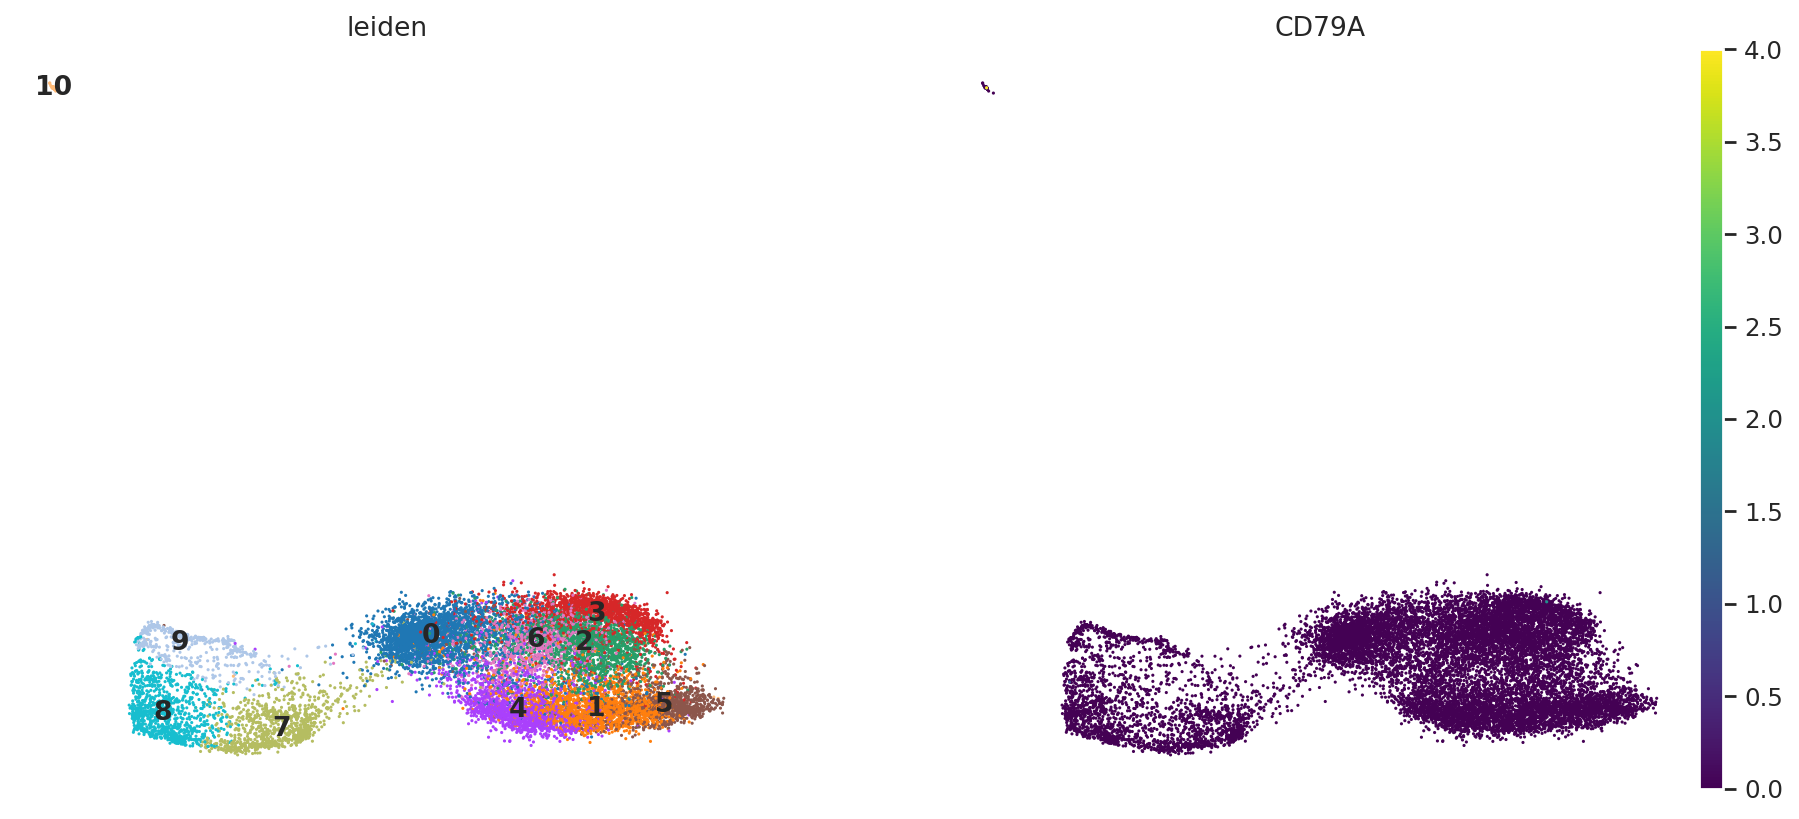

In [43]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CD79A'],
    frameon=False,
    ncols=3,
    cmap='viridis',
    legend_loc='on data',
    legend_fontsize=12
)

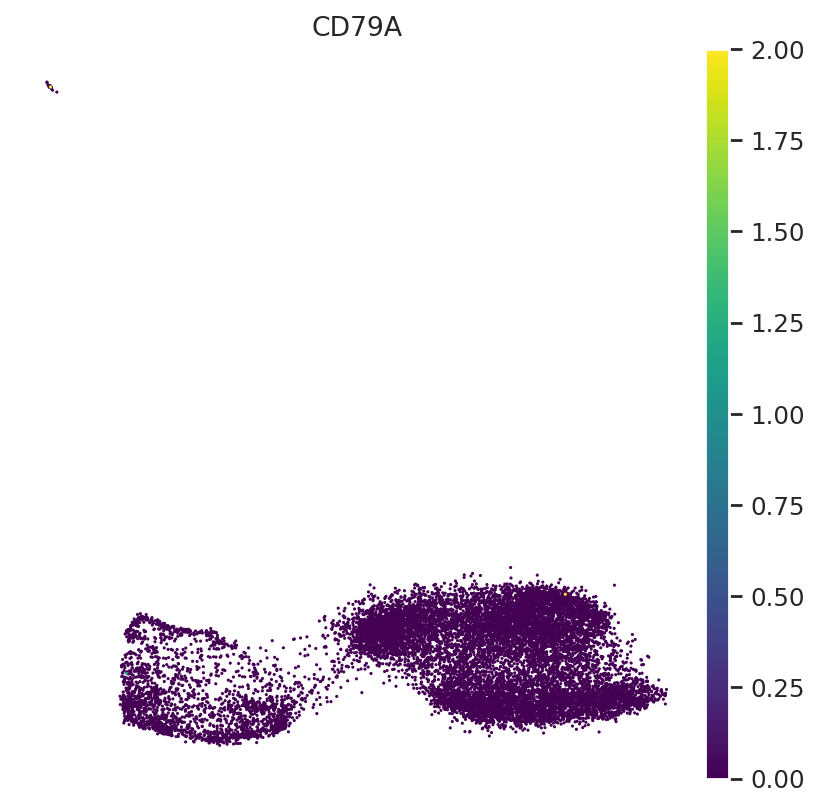

In [44]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['CD79A'],
    frameon=False,
    ncols=3,
    cmap='viridis',
    legend_loc='on data',
    legend_fontsize=12,
    vmax=2
)

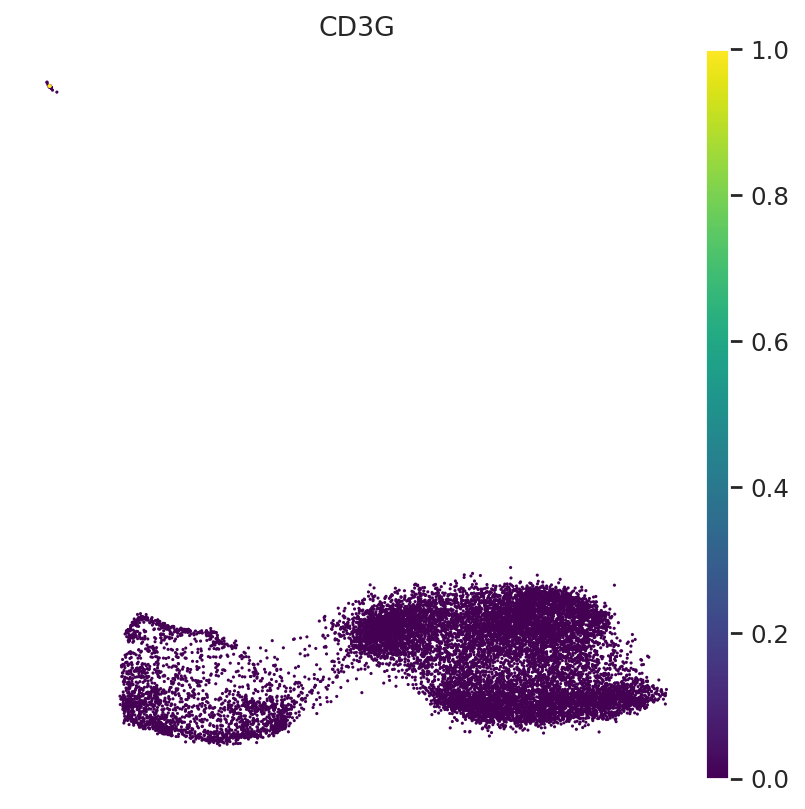

In [45]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['CD3G'],
    frameon=False,
    ncols=3,
    cmap='viridis',
    legend_fontsize=12
)

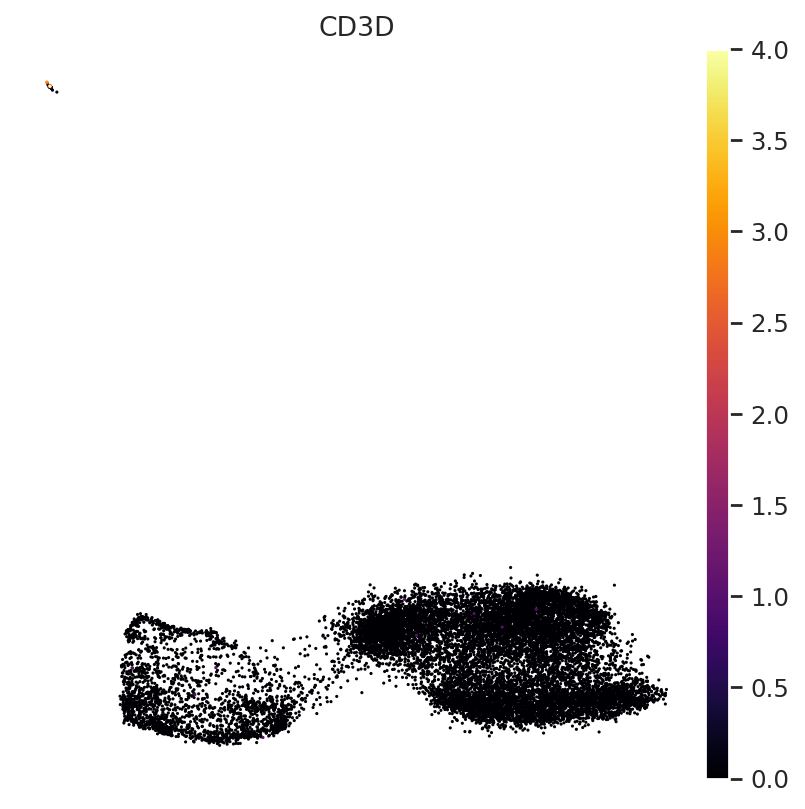

In [46]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['CD3D'],
    frameon=False,
    ncols=3,
    cmap='inferno',
    legend_loc='on data',
    legend_fontsize=12
)

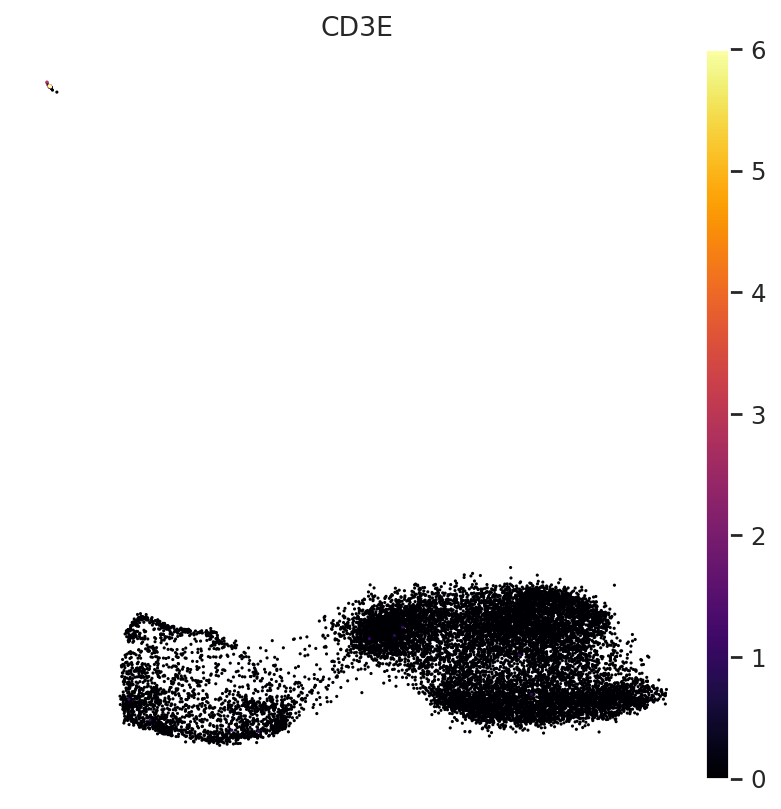

In [47]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['CD3E'],
    frameon=False,
    ncols=3,
    cmap='inferno',
    legend_loc='on data',
    legend_fontsize=12
)

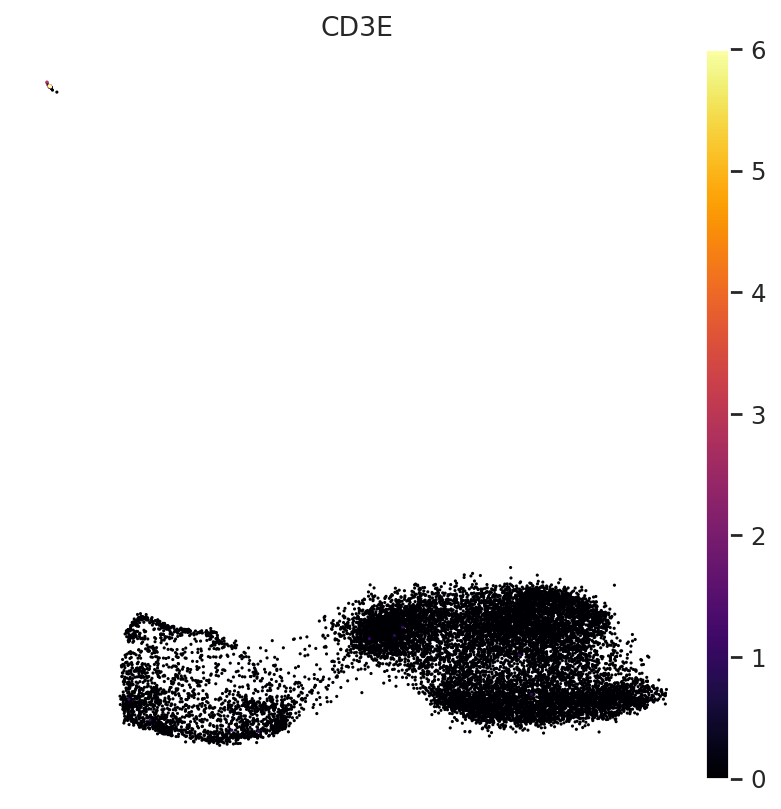

In [67]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['CD3E'],
    frameon=False,
    ncols=3,
    cmap='inferno',
    legend_loc='on data',
    legend_fontsize=12
)

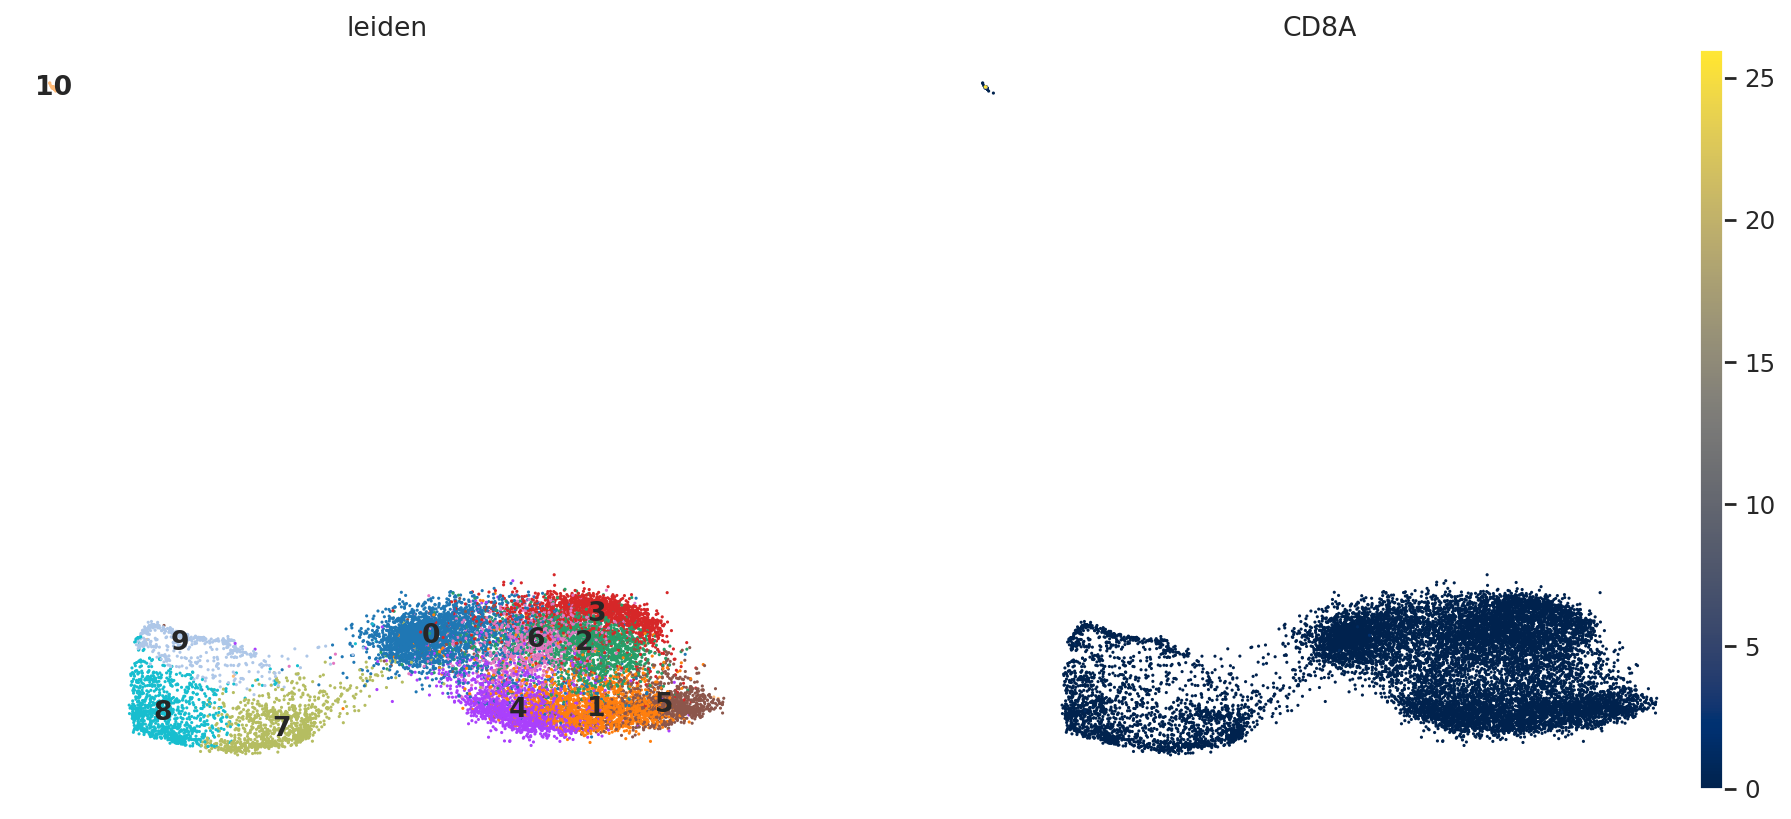

In [66]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CD8A'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

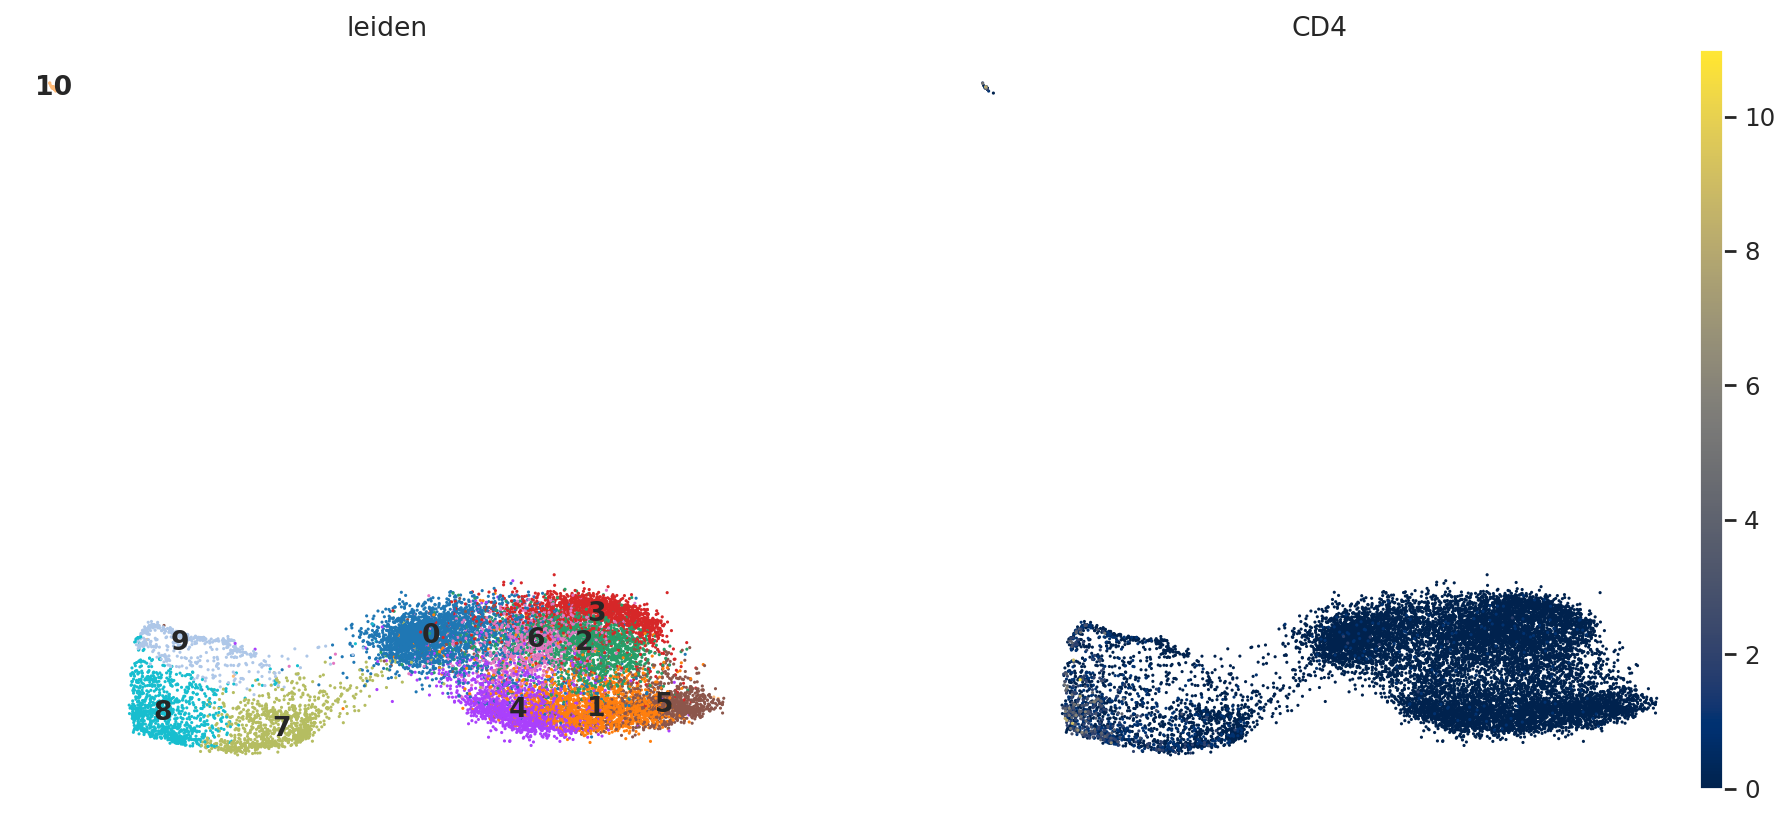

In [65]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CD4'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

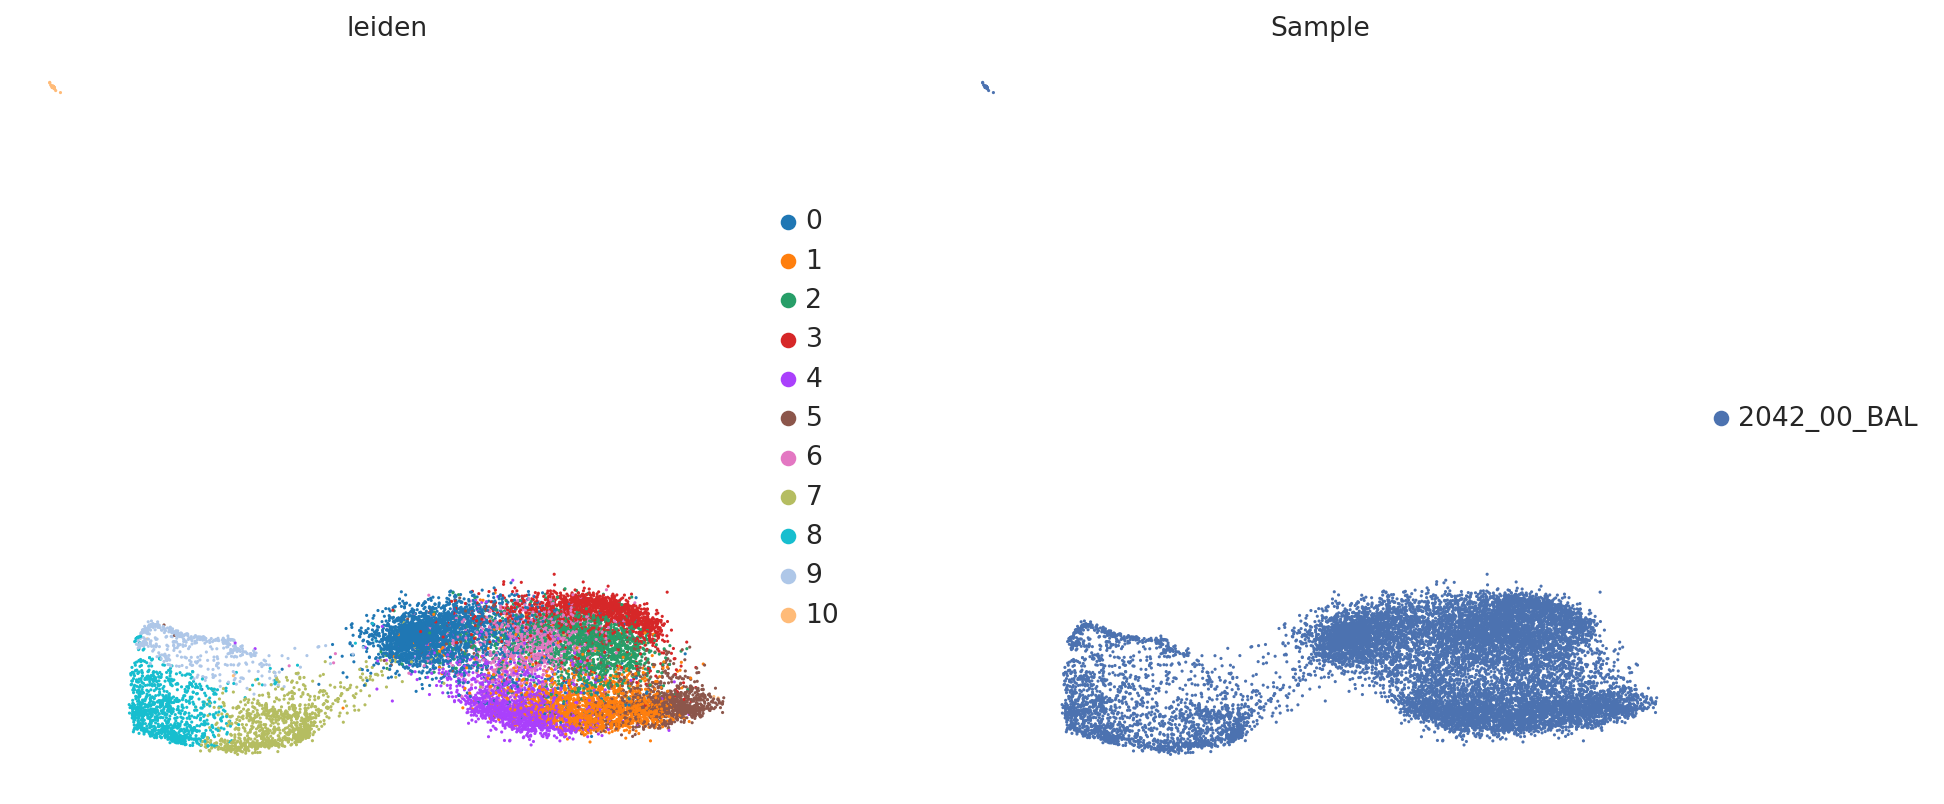

In [51]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'Sample'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_fontsize=12,
    vmin=0,
    vmax=2
)

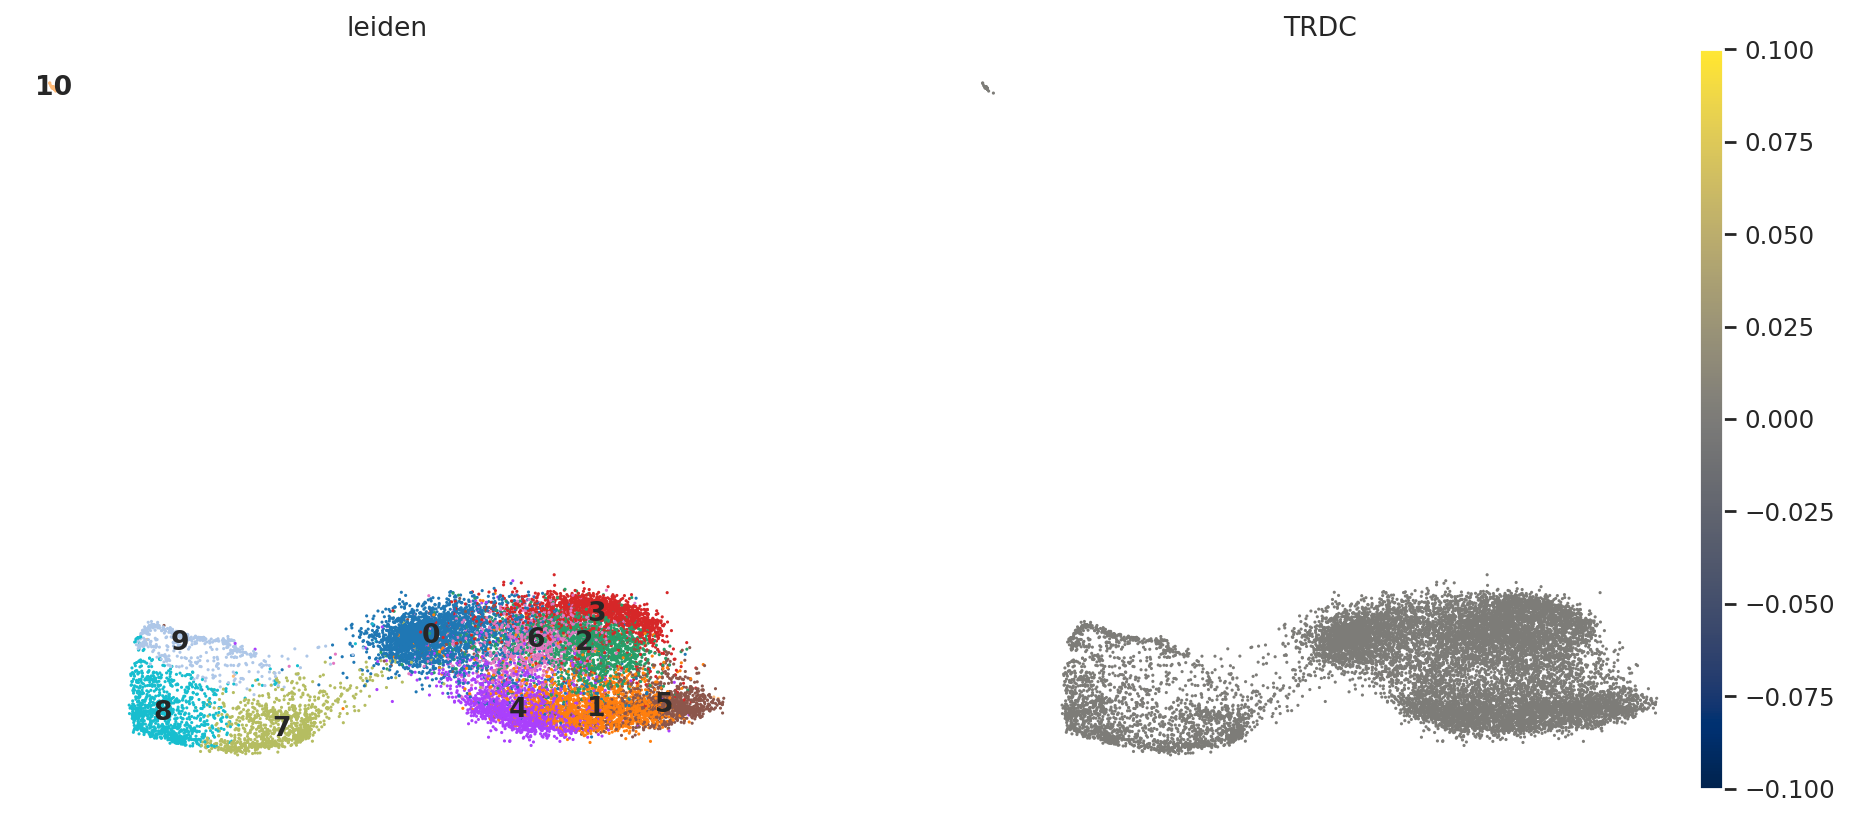

In [52]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'TRDC'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

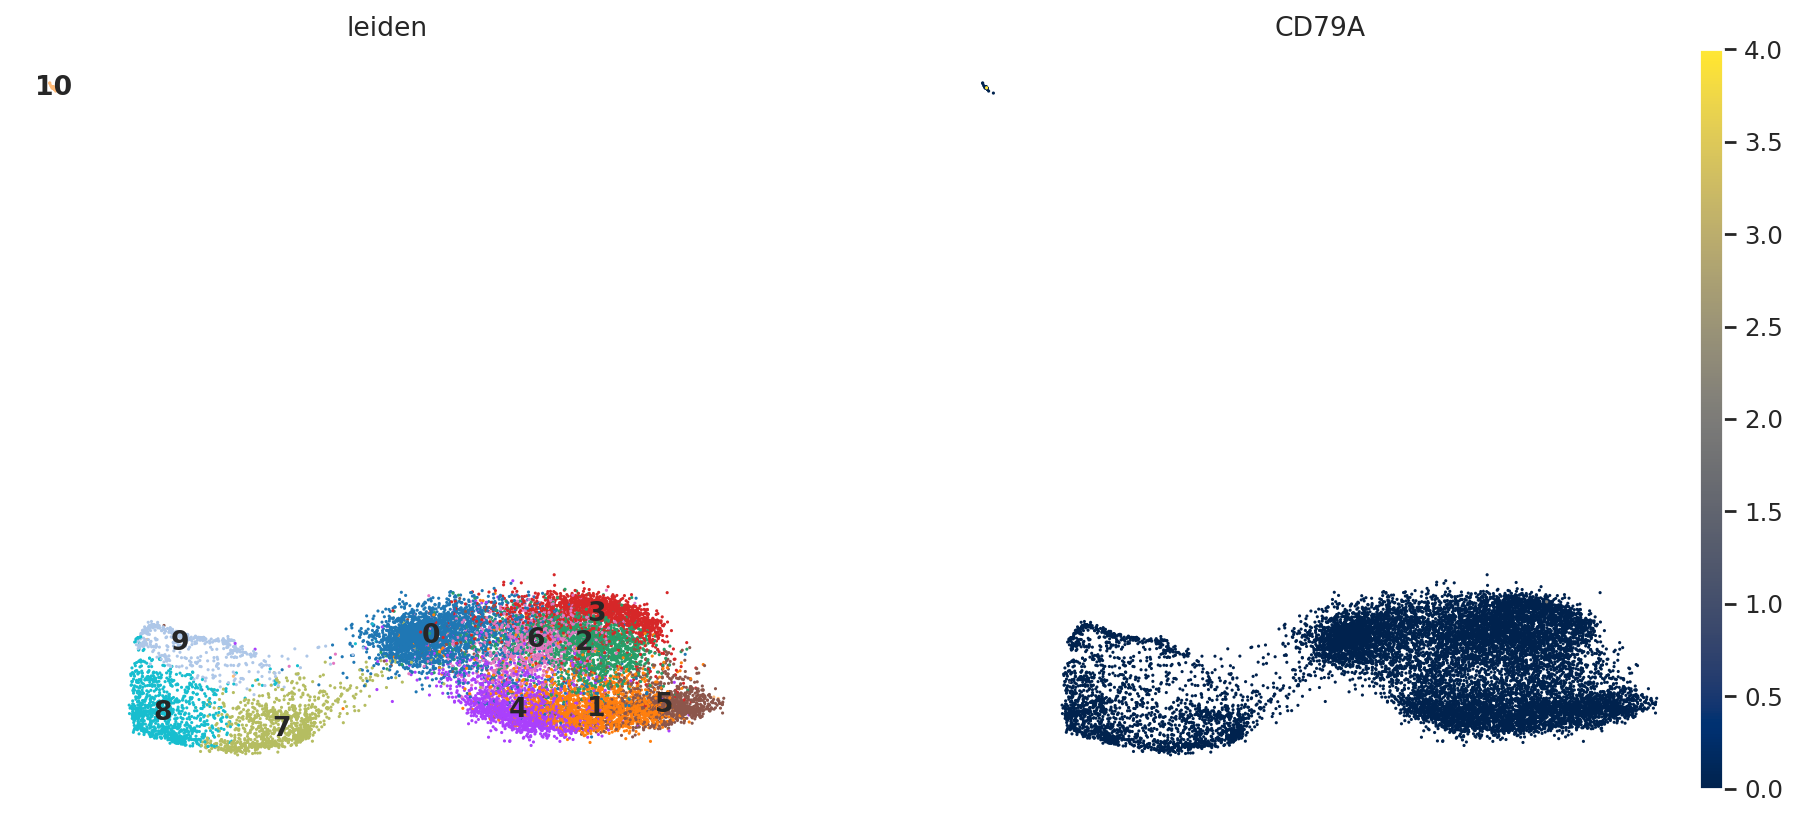

In [53]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CD79A'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

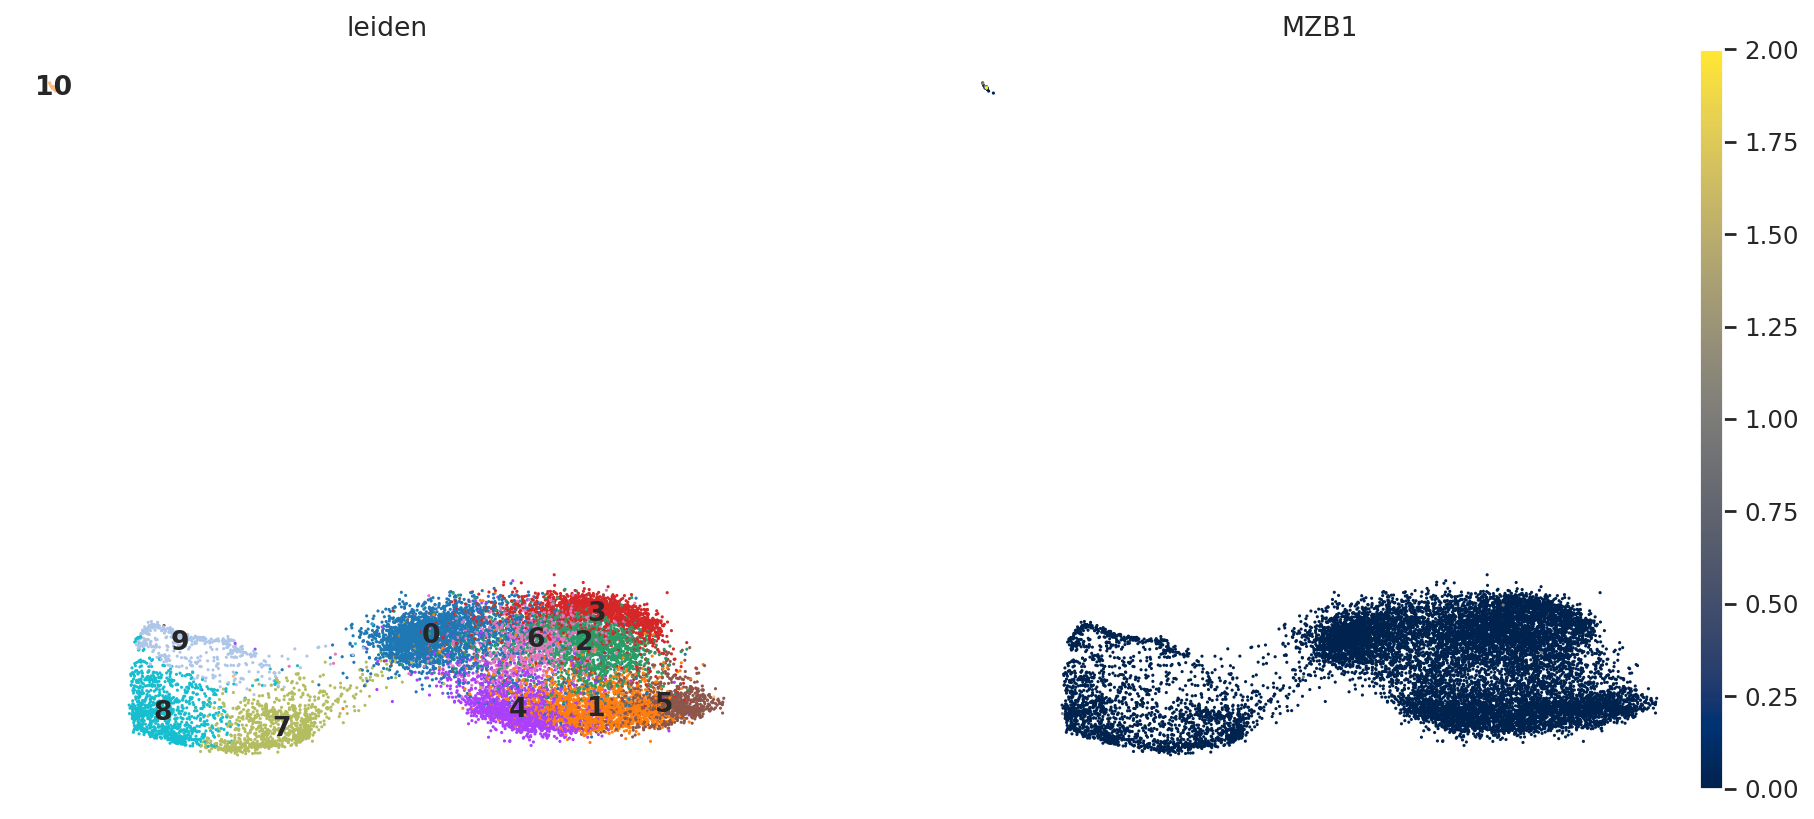

In [54]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'MZB1'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

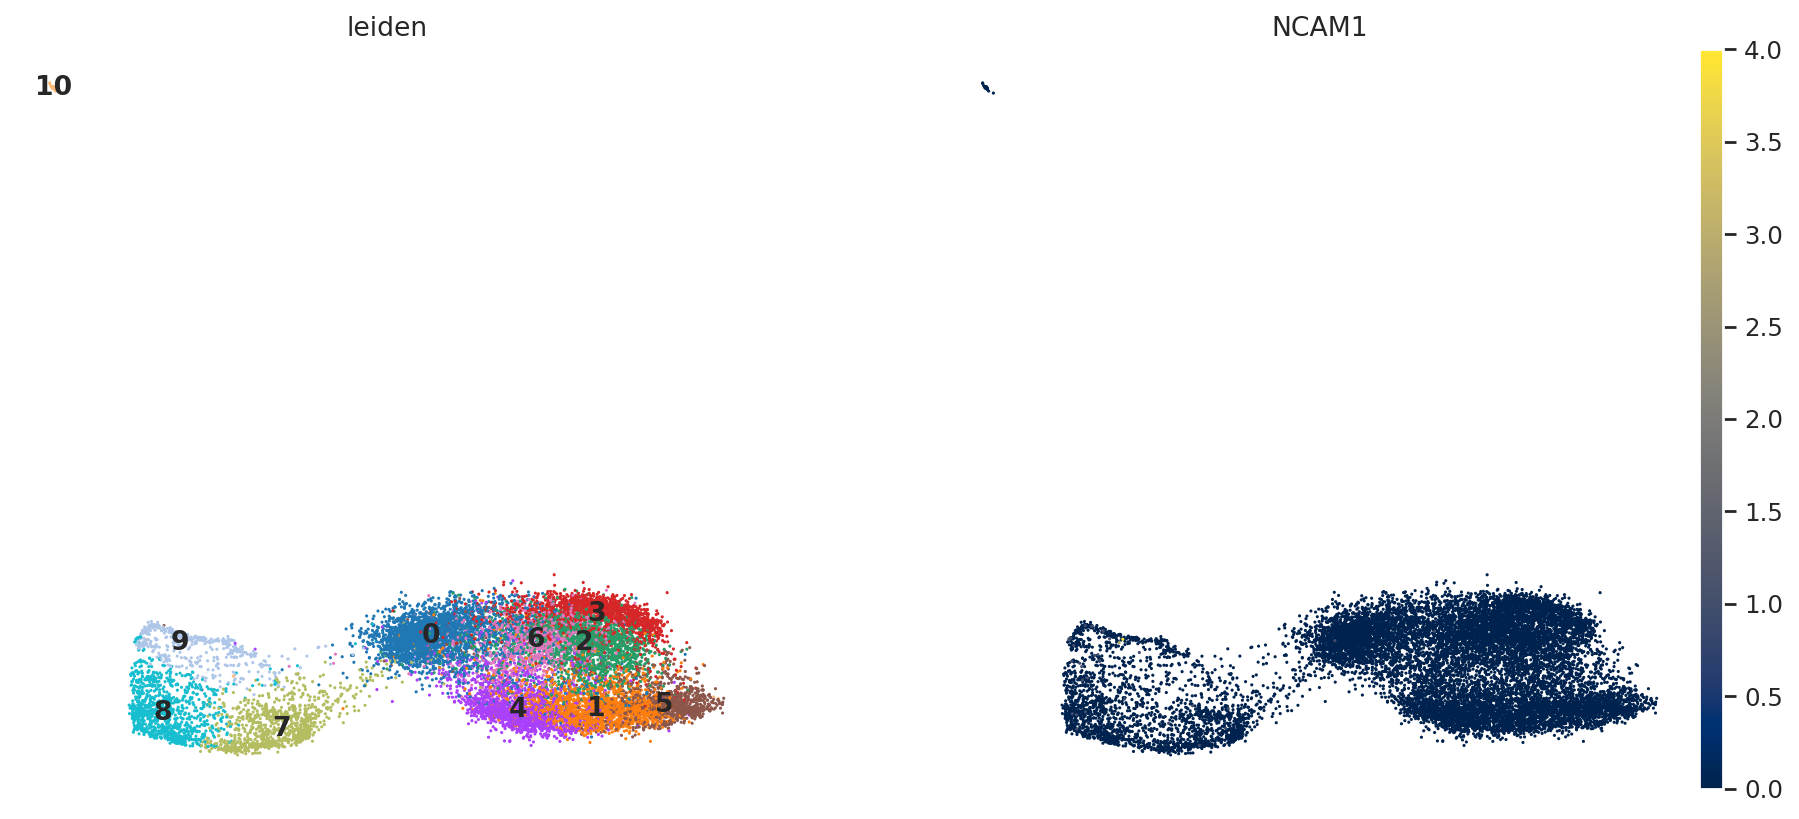

In [55]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'NCAM1'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

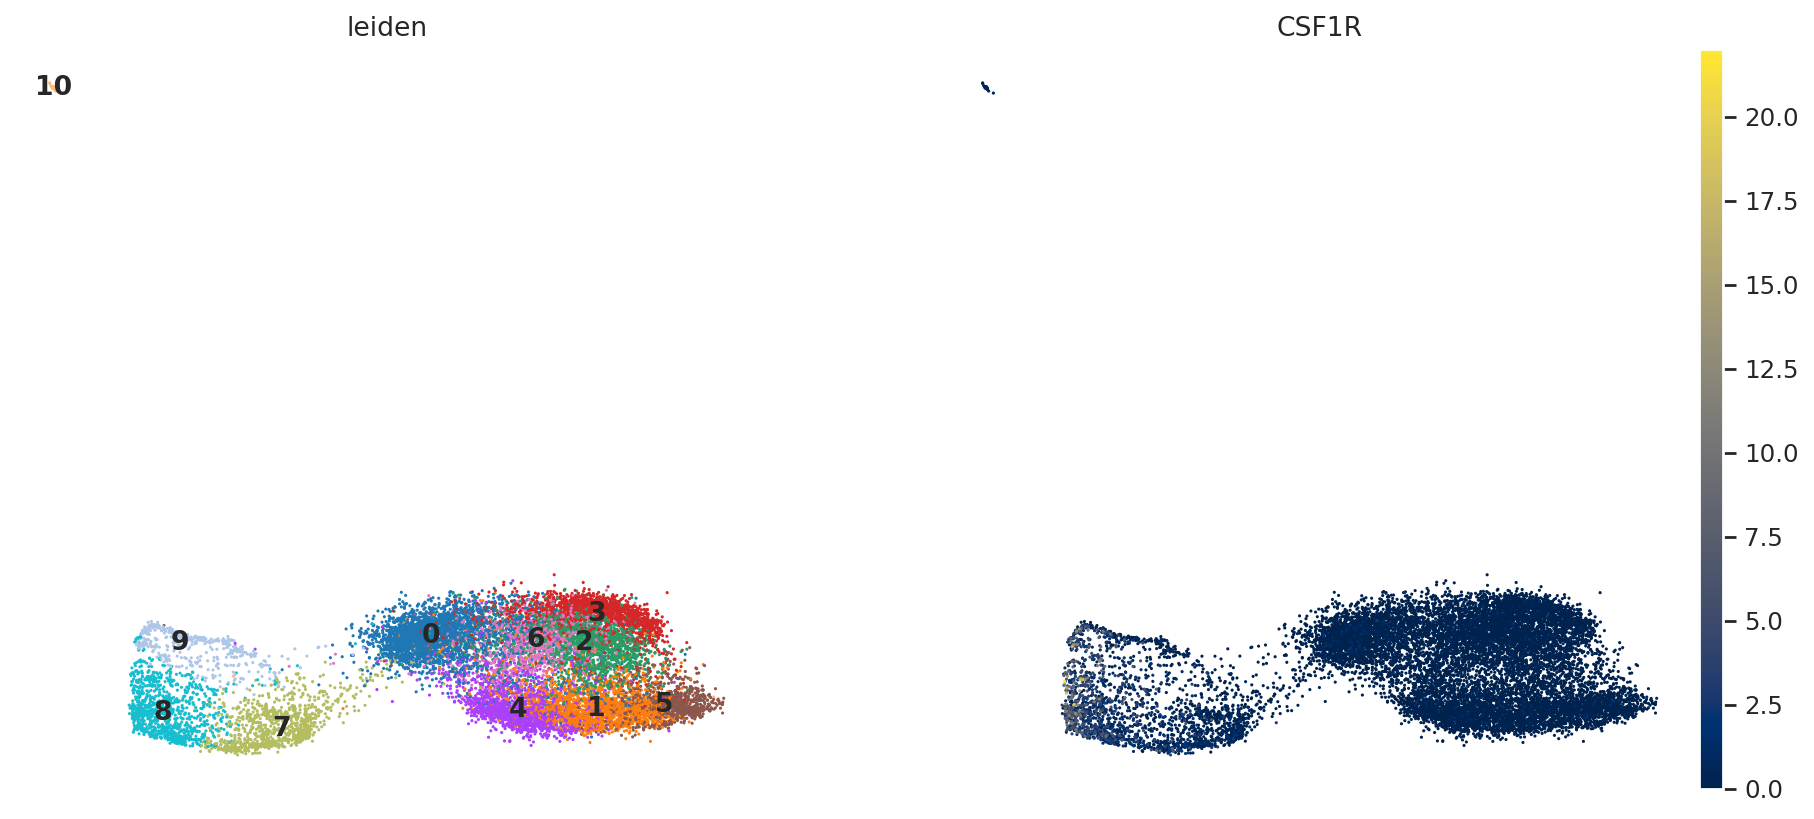

In [56]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CSF1R'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

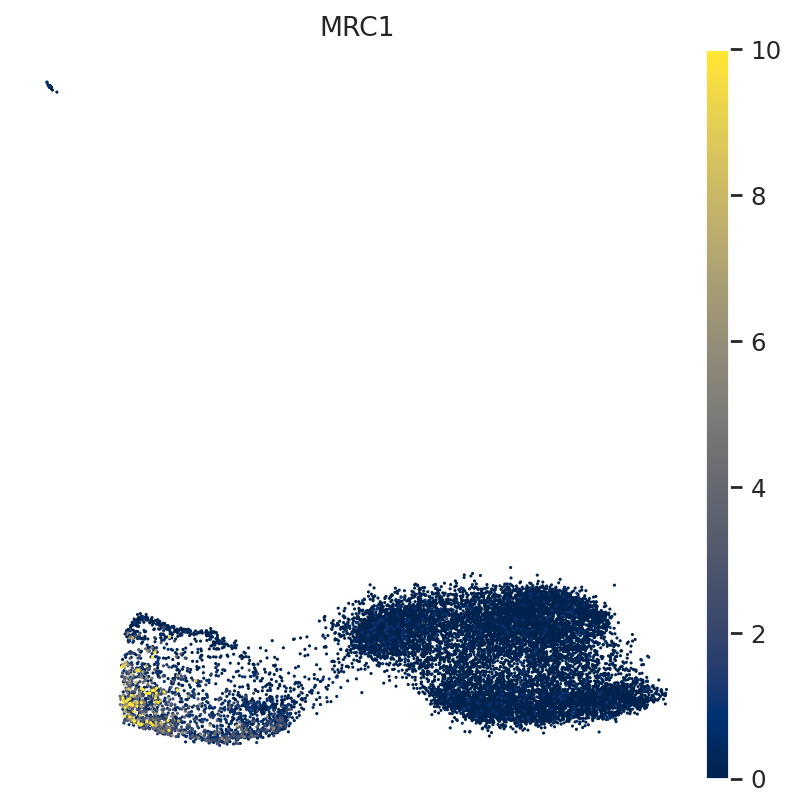

In [57]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['MRC1'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12,
    vmax=10
)

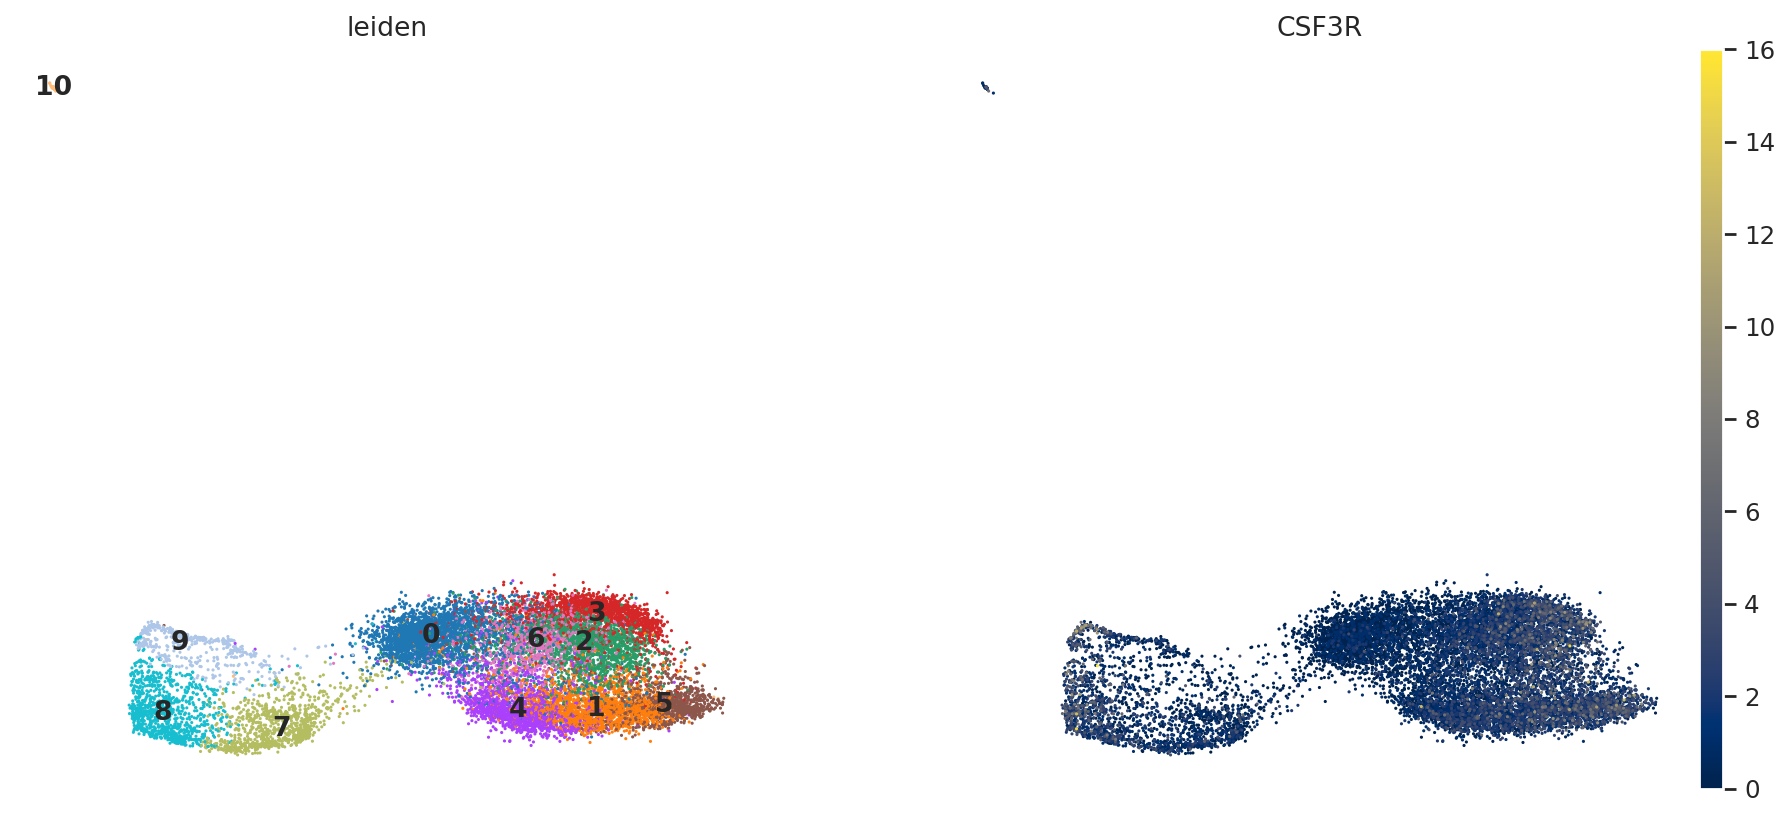

In [58]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'CSF3R'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12
)

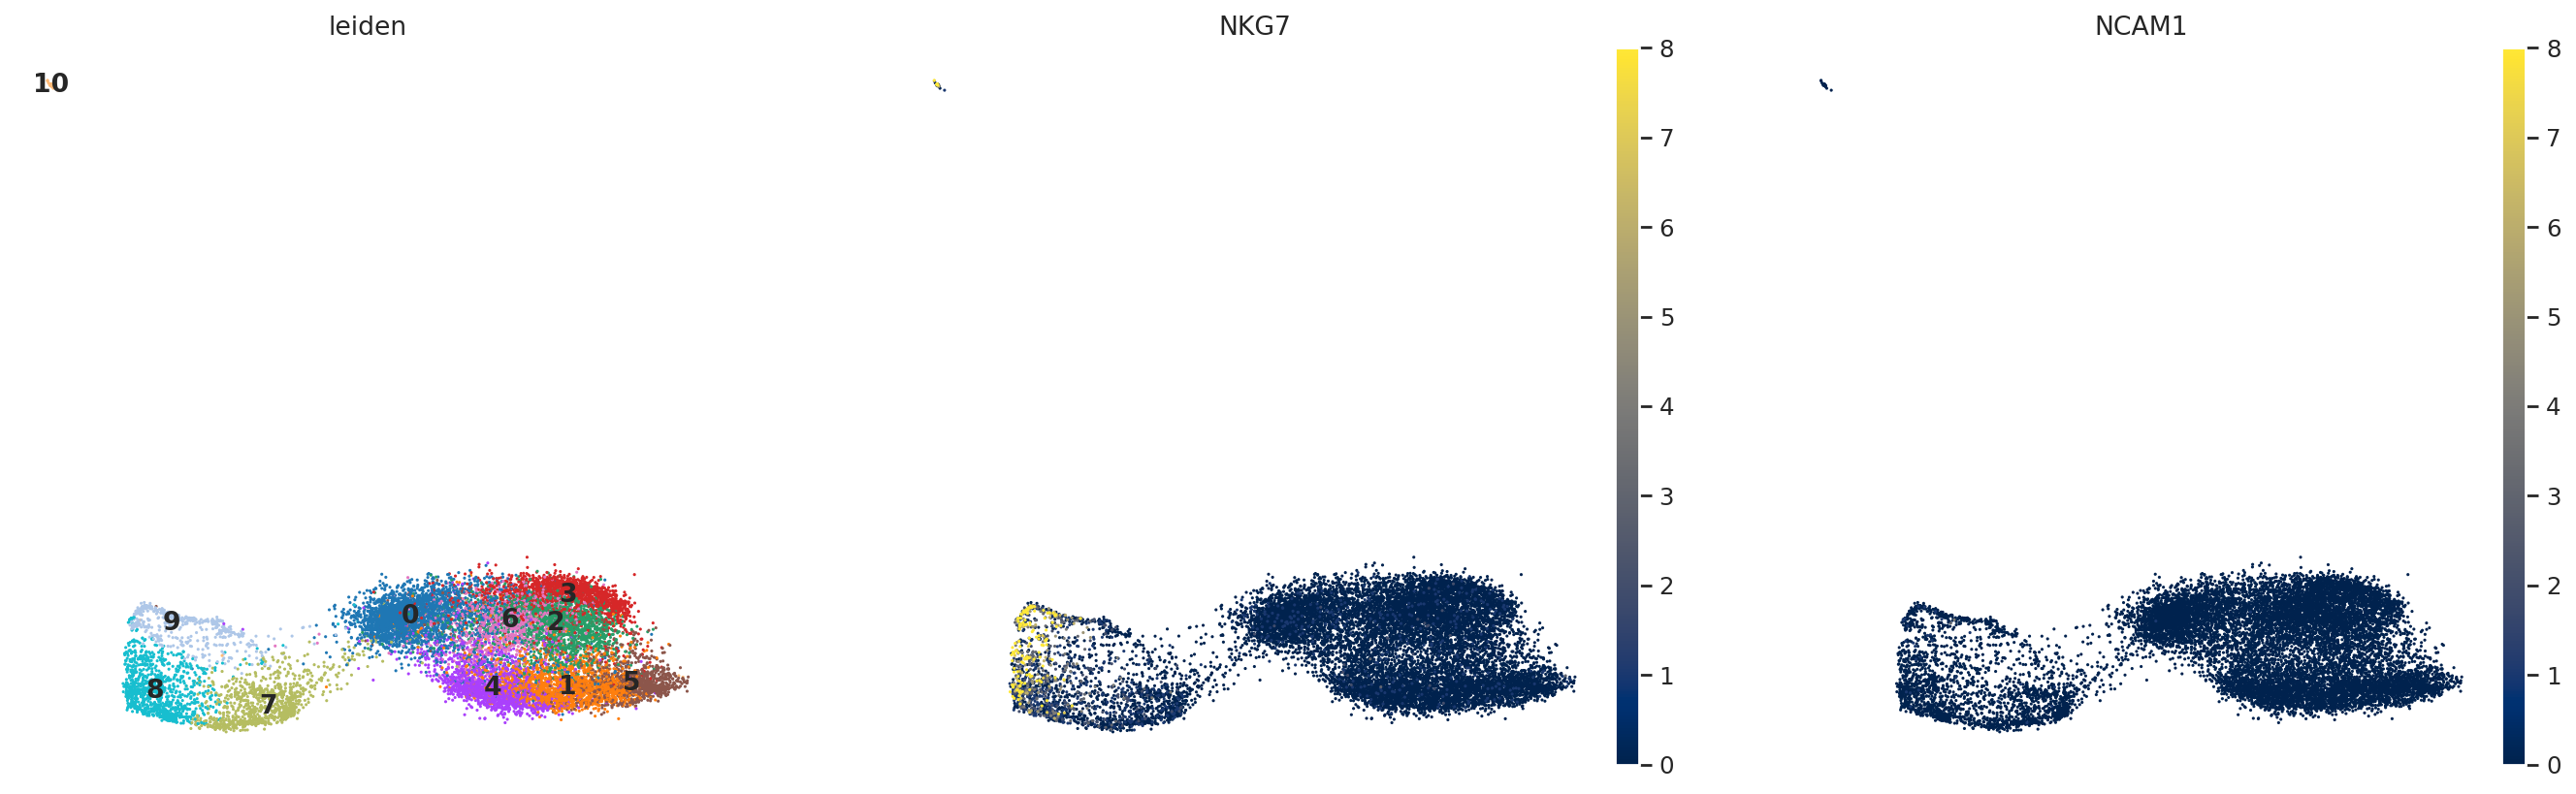

In [61]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['leiden', 'NKG7','NCAM1'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_loc='on data',
    legend_fontsize=12,
    vmin=0,
    vmax=8
)

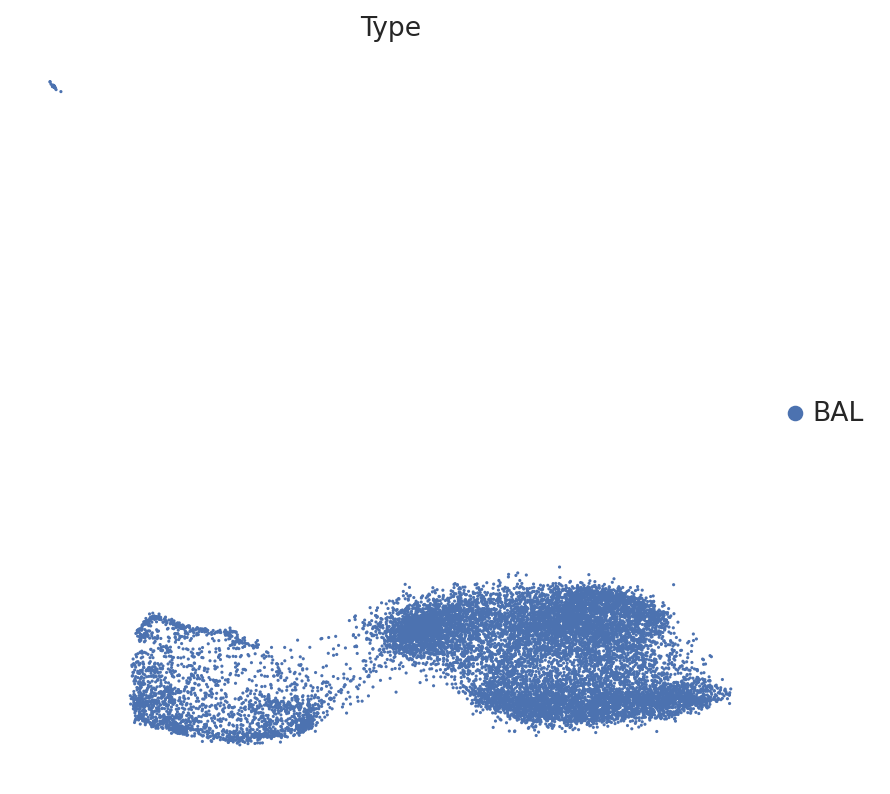

In [62]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=['Type'],
    frameon=False,
    ncols=3,
    cmap='cividis',
    legend_fontsize=12
)

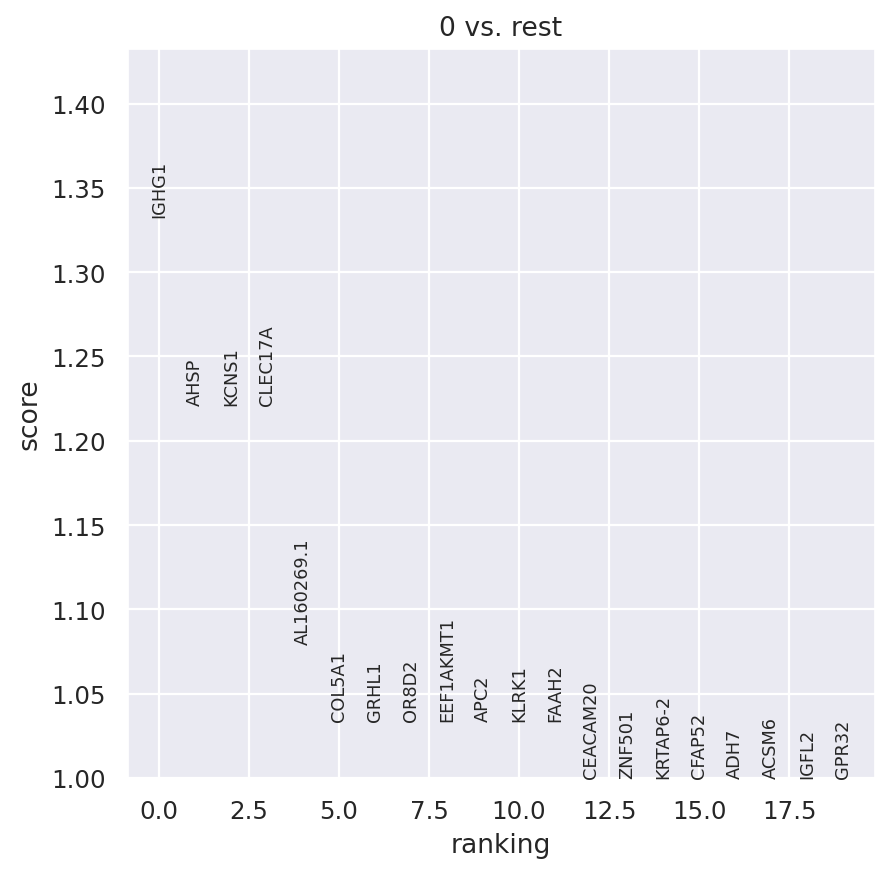

In [63]:
cluster_0_cells = adata[adata.obs['leiden'] == '0']

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='rest')

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

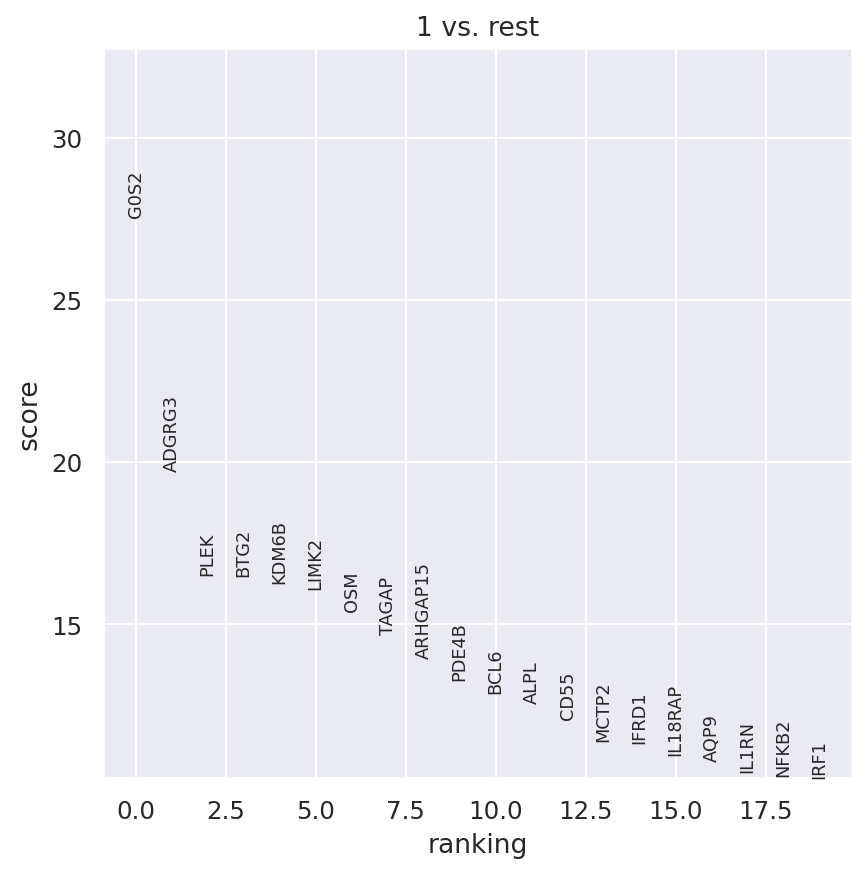

In [64]:
cluster_1_cells = adata[adata.obs['leiden'] == '1']

sc.tl.rank_genes_groups(adata, 'leiden', groups=['1'], reference='rest')

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [77]:
clusters_to_keep = ['0','1','2','3','4','5','6']

In [78]:
adata_sub = adata[adata.obs['leiden'].isin(clusters_to_keep)].copy()

In [79]:
scvi.model.SCVI.setup_anndata(adata_sub)

In [80]:
model = scvi.model.SCVI(adata_sub)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████| 400/400 [06:51<00:00,  1.01s/it, v_num=1, train_loss_step=437, train_loss_epoch=421]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████| 400/400 [06:51<00:00,  1.03s/it, v_num=1, train_loss_step=437, train_loss_epoch=421]


In [81]:
SCVI_LATENT_KEY = "X_scVI"
adata_sub.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [82]:
sc.pp.neighbors(adata_sub, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_sub)

In [89]:
if 'X_scVI_MDE' in adata_sub.obsm.keys():
    del adata_sub.obsm['X_scVI_MDE']

In [90]:
from scvi.model.utils import mde

SCVI_MDE_KEY = "X_scVI_MDE"
SCVI_LATENT_KEY = "X_scVI"

if adata_sub.obsm[SCVI_LATENT_KEY].shape[0] == adata_sub.shape[0]:
    adata_sub.obsm[SCVI_MDE_KEY] = mde(adata_sub.obsm[SCVI_LATENT_KEY])
else:
    print(f"Shape mismatch: {adata_sub.obsm[SCVI_LATENT_KEY].shape[0]} vs {adata_sub.shape[0]}")


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [91]:
import torch
import tempfile
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

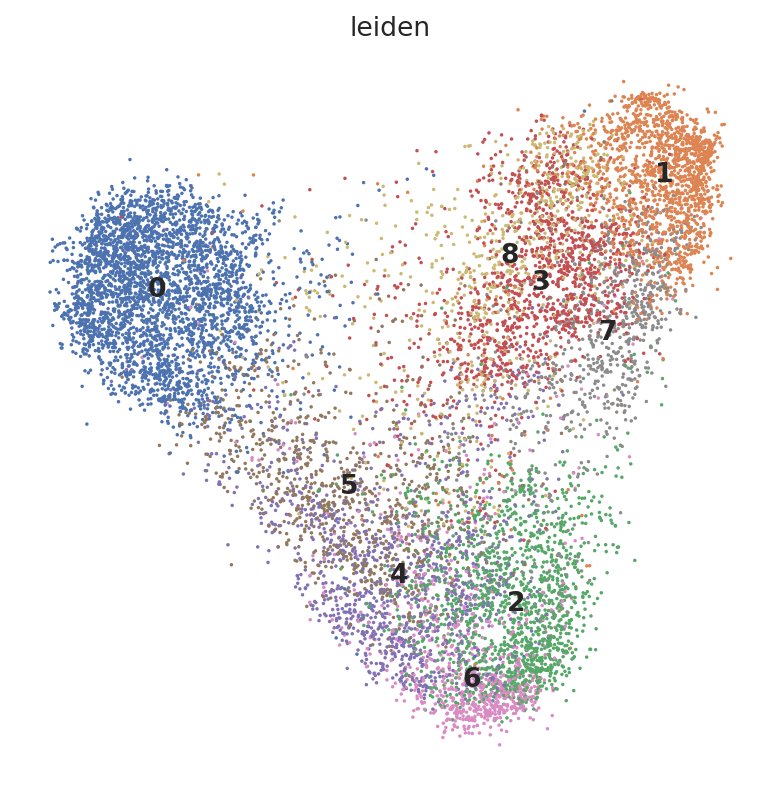

In [102]:
sc.pl.embedding(
    adata_sub,
    basis=SCVI_MDE_KEY,
    color=["leiden"],
    frameon=False,
    ncols=1,
    legend_loc='on data'
)

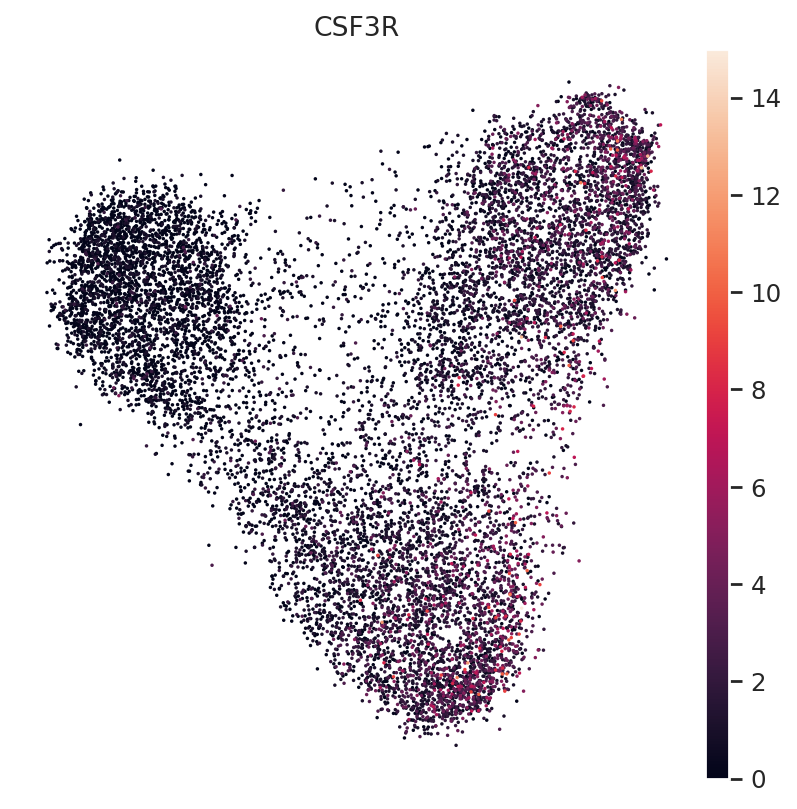

In [100]:
sc.pl.embedding(
    adata_sub,
    basis=SCVI_MDE_KEY,
    color=["CSF3R"],
    frameon=False,
    ncols=1
)

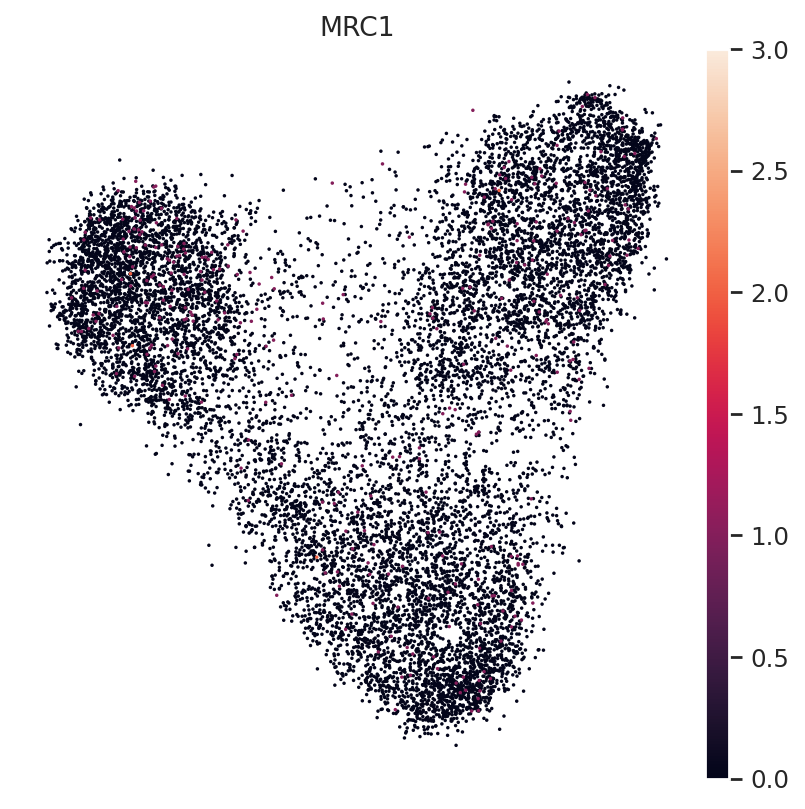

In [99]:
sc.pl.embedding(
    adata_sub,
    basis=SCVI_MDE_KEY,
    color=["MRC1"],
    frameon=False,
    ncols=1
)

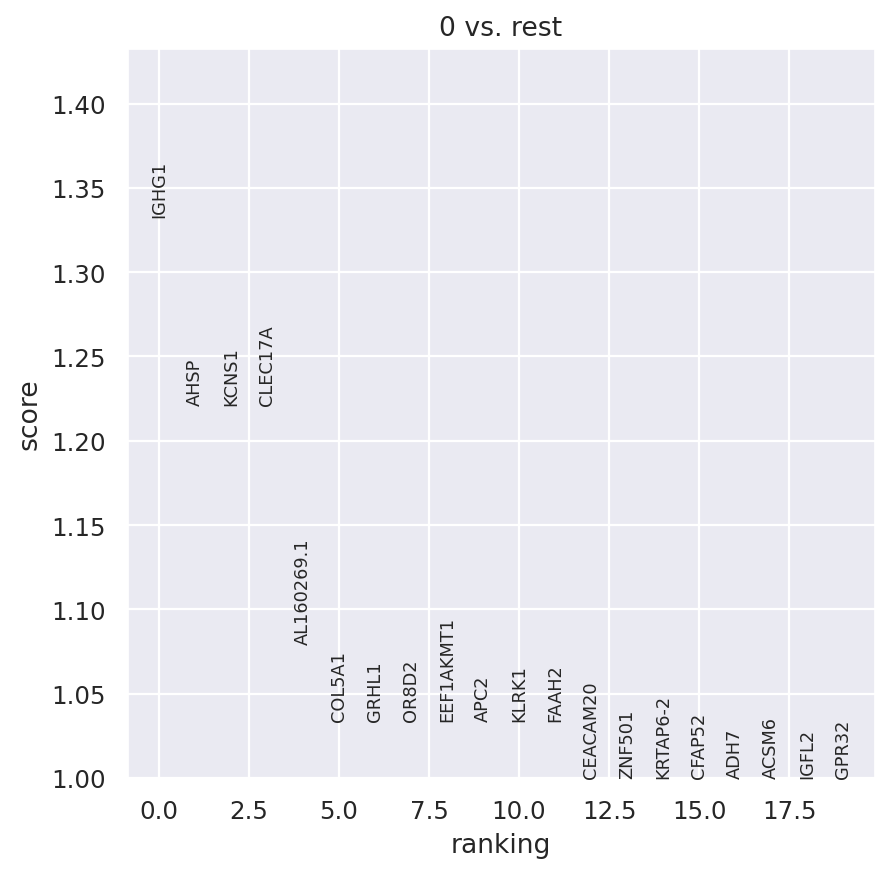

In [103]:
cluster_0_cells = adata[adata.obs['leiden'] == '0']

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='rest')

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [110]:
cluster_counts = adata_sub.obs['leiden'].value_counts()
print(cluster_counts)


leiden
0    3269
1    1572
2    1501
3    1348
4    1189
5     961
6     855
7     757
8     748
Name: count, dtype: int64
